# Imports

In [1]:
import os
import copy
import csv
import math
import numpy as np
import pandas as pd
from tqdm.auto import tqdm
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
from matplotlib.ticker import MaxNLocator
import matplotlib.pyplot as plt

np.random.seed(0)
np.seterr(divide = 'ignore') 
plt.style.use('seaborn-paper')

# Dataset

## Loading dataset

In [2]:
!gdown 11qXv2vipvTPVVKyB2x_otsl1s3sSvonk
!unzip -o data.zip -d data

Downloading...
From: https://drive.google.com/uc?id=11qXv2vipvTPVVKyB2x_otsl1s3sSvonk
To: /content/data.zip
100% 18.5k/18.5k [00:00<00:00, 26.4MB/s]
Archive:  data.zip
  inflating: data/Contextual_data.xlsx  
   creating: data/samples/
  inflating: data/samples/sample_1.csv  
  inflating: data/samples/sample_11.csv  
  inflating: data/samples/sample_12.csv  
  inflating: data/samples/sample_13.csv  
  inflating: data/samples/sample_14.csv  
  inflating: data/samples/sample_15.csv  
  inflating: data/samples/sample_16.csv  
  inflating: data/samples/sample_18.csv  
  inflating: data/samples/sample_19.csv  
  inflating: data/samples/sample_2.csv  
  inflating: data/samples/sample_20.csv  
  inflating: data/samples/sample_21.csv  
  inflating: data/samples/sample_23.csv  
  inflating: data/samples/sample_24.csv  
  inflating: data/samples/sample_25.csv  
  inflating: data/samples/sample_3.csv  
  inflating: data/samples/sample_4.csv  
  inflating: data/samples/sample_5.csv  
  inflating: 

In [3]:
excel_data = pd.read_excel('data/Contextual_data.xlsx',engine='openpyxl')

Y = list()
for _id in excel_data['sample no.']:
    sample_path = 'data/samples/sample_{}.csv'.format(_id)
    if os.path.exists(sample_path):
        Y.append(pd.read_csv(sample_path))

In [4]:
Y_train, Y_test, Y_train_idx, Y_test_idx = train_test_split(Y, list(range(len(Y))), test_size=1)

# Utils

In [5]:
def log(x):
    if x < 0:
        raise ValueError('Negative value encoutered', x)
    elif x == 0:
        return -np.inf
    else:
        return np.log(x)

In [6]:
def exp(x):
    if x == -np.inf:
        return 0
    elif x == np.inf:
        raise ValueError('Positive infinity in epx')
    else:
        return np.exp(x)

In [7]:
def log_sum(ln_x, ln_y):
    # implementation based on Algorithm 3 of link http://bozeman.genome.washington.edu/compbio/mbt599_2006/hmm_scaling_revised.pdf
    if ln_x == -np.inf or ln_y == -np.inf:
        # Note: if both ln_x and ln_y were -inf we inevitably return -inf
        if ln_x == -np.inf:
            return ln_y
        else:
            return ln_x 
    else:
        if ln_x > ln_y:
            return ln_x + log(1 + exp(ln_y - ln_x))
        else:
            return ln_y + log(1 + exp(ln_x - ln_y))

In [8]:
def log_product(ln_x, ln_y):
    # implementation based on Algorithm 4 of link http://bozeman.genome.washington.edu/compbio/mbt599_2006/hmm_scaling_revised.pdf
    if ln_x == -np.inf or ln_y == -np.inf:
        return -np.inf
    else:
        return ln_x + ln_y

## Checking sample lengths

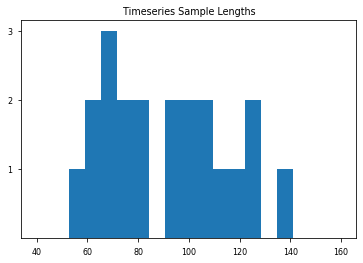

In [9]:
lengths = []
for y in Y:
    lengths.append(len(y))

plt.hist(lengths, np.linspace(40, 160, 20))
plt.yticks([1,2,3])
plt.title('Timeseries Sample Lengths')
plt.show()

## Cleaning data

In [10]:
def clean_batch(batch):

    def _clean_sample(sample):
        out = sample.copy()

        out.drop('Unnamed: 0', axis=1, inplace=True)

        for col in out.columns:
            out[col].fillna(out[col].mode()[0], inplace=True)
        
        out = out[['f1', 'f2', 'f3', 'f4', 'f5', 'target']]
        out = out[(out.target==1)|(out.target==2)]
        out.reset_index(drop=True, inplace=True)

        out.target -= 1 # so can be used as index

        return out

    cleaned_batch = list()
    for sample in batch:
        cleaned_batch.append(_clean_sample(sample))
    return cleaned_batch

# Constants

In [11]:
STATE = [0, 1]
CONTEXT_COLUMN = 'c1'
CONTEXT = list(set(excel_data.c1))
FEATURE = [0, 1, 2, 3, 4]
NUMBER_STATE = 2
TIME_SERIES_LENGTH = 160
SMALL_VALUE = 1e-9

# Hidden Markov Models

## Sum-product

### $\alpha$, $\beta$ recursions

Implement the $\alpha$ and $\beta$-recursions.

Recall that $\alpha(x_t) := p(x_t, y_{1:t})$, $\beta(x_t) := p(y_{(t+1):T} | x_t)$. Implement also a function to compute the emission probabilties $\epsilon_k(y_t) := p(y_t|x_t=k)$.

For numerical stability reasons, you can implement your algorithms using **log probabilities**!



In [12]:
def comp_transition(Y_idx, Y):
    # Note: Y is BATCH of time series samples

    # initialization
    M = {context:np.zeros((NUMBER_STATE, NUMBER_STATE)) for context in CONTEXT}

    # frequency count
    for y_idx, y in zip(Y_idx, Y):
        pst = y.target[0]
        context = excel_data.iloc[y_idx][CONTEXT_COLUMN]
        for st in y.target[1:]:
            M[context][pst-1, st-1] += 1
            pst = st
    
    # normalization
    for context in CONTEXT:
        for st in STATE:
            total_freq = sum(cnt for cnt in M[context][st]) + 1e-9 # add with small number to avoid Division by zero
            M[context][st] = np.array([cnt/total_freq for cnt in M[context][st]])
    
    return M

def emission_prob(eps, context, state, obs):
    prob = 1
    for fi in FEATURE:
        prob *= eps[context][state][fi].get(obs[fi], 0) + 1e-9 # Add very little prob for numerically stable reason.
    return prob

def emission(Y_idx, Y):
    # Note: Y is a BATCH of time series samples

    # initialization
    eps = {context:dict() for context in CONTEXT}
    for context in CONTEXT:
        eps[context] = {st: dict() for st in STATE}
        for fi in FEATURE:
            for st in STATE:
                eps[context][st][fi] = dict()

    # frequency count
    for y_idx, y in zip(Y_idx, Y):
        context = excel_data.iloc[y_idx][CONTEXT_COLUMN]
        for t, ins in y.iterrows():
            *obs, state = ins
            for fi in FEATURE:
                if obs[fi] not in eps[context][state][fi]:
                    eps[context][state][fi][obs[fi]] = 0
                eps[context][state][fi][obs[fi]] += 1
        
    # normalization
    for context in CONTEXT:
        for st in STATE:
            for fi in eps[context][st]:
                total_freq_fi = sum(eps[context][st][fi][fv] for fv in eps[context][st][fi])
                eps[context][st][fi] = {fv: eps[context][st][fi][fv]/total_freq_fi for fv in eps[context][st][fi]}

    return eps

def alpha_recursion(Y, M, eps, pi, context):
    # Note: Y is SINGLE time series sample
    # implemented based on Algorithm 5
    # Solution for numerical issues are based on https://courses.engr.illinois.edu/ece417/fa2020/slides/lec14.pdf

    # initialization step
    log_alpha = np.zeros((TIME_SERIES_LENGTH, NUMBER_STATE))
    for st in STATE:
        *obs, _ = Y.iloc[0]
        log_alpha[0, st] = log_product(log(pi[st]), log(emission_prob(eps, context, st, obs)))

    # recursion step
    for t, vars in Y.iloc[1:].iterrows():
        *obs, _ = vars
        for stj in STATE:
            log_a = -np.inf
            for sti in STATE:
                log_a = log_sum(log_a, log_product(log_alpha[t-1, sti], log(M[context][sti][stj])))
            log_alpha[t, stj] = log_product(log_a, log(emission_prob(eps, context, stj, obs)))

    return log_alpha

def beta_recursion(Y, M, eps, context) :
    # Note: Y is SINGLE time series sample
    # Implementation is based on Algorithm 6

    # initialization step
    T = len(Y)
    log_beta = np.zeros((TIME_SERIES_LENGTH, NUMBER_STATE))
    for st in STATE:
        log_beta[T-1, st] = 0

    # recursion step
    for t in reversed(range(T-1)):
        *nobs, _ = Y.iloc[t+1]
        for sti in STATE:
            log_b = -np.inf
            for stj in STATE:
                log_b = log_sum(log_b, 
                                log_product(log(M[context][sti][stj]),
                                            log_product(emission_prob(eps, context, stj, nobs),
                                                        log_beta[t+1, stj])
                                            )
                                )
            log_beta[t, sti] = log_b
    return log_beta

Using the two functions above, implement the computation of the *smoothing* distribution $p(x_t|y_1,\dots,y_T)$ and pair-marginals $p(x_t,x_{t+1}|y_1,\dots,y_T)$. Here use log probabilities from the $\alpha$ and $\beta$, but return a normal (not log!) probability, i.e, a number in $[0,1]$.

In [13]:
def smoothing(log_alpha, log_beta):
    T, K = alpha.shape

    log_gamma = np.zeros((T, K))
    for t in range(T):
        normalizer = -np.inf
        for st in STATE:
            log_gamma[t, st] = log_product(log_alpha[t,st], log_beta[t,st])
            normalizer = log_sum(normalizer, log_gamma[t, st])

        for st in STATE:
            log_gamma[t, st] = log_product(log_gamma[t,st], -normalizer)

    return log_gamma

def pair_marginals(Y, log_alpha, log_beta, M, eps, context):
    T, K = alpha.shape

    log_psi = np.zeros((T, K, K))
    for t in range(len(Y) - 1):
        *nobs, _ = Y.iloc[t+1]
        normalizer = -np.inf
        for sti in STATE:
            for stj in STATE:
                log_psi[t, sti, stj] = log_product(log_alpha[t, sti], 
                                                   log_product(log(M[context][sti, stj]),
                                                               log_product(log(emission_prob(eps, context, stj, nobs)),
                                                                           log_beta[t+1, stj]
                                                                           )
                                                               )
                                                   )
                normalizer = log_sum(normalizer, log_psi[t, sti, stj])

        for sti in STATE:
            for stj in STATE:
                log_psi[t, sti, stj] = log_product(log_psi[t, sti, stj], -normalizer)

    return log_psi

Let $\{y_1,\dots,y_T\}$ be the **test** data. Using your functions above, for all $t$ on the test data, compute $\alpha_t$, $\beta_t$ and  $p(x_t | y_1,\dots,y_T)$. Finally, plot $p(x_t|y_1,\dots,y_T)$ for each of the 2 states as a function of $t$ for one sample. 

In [14]:
def plot_smoothing(gamma, K=2, time_limit=160):
    plt.figure(figsize=(14, 2*K))
    plt.suptitle('Smoothing probabilities $p(z_t|x_1, ..., x_T)$', fontsize=16)
    for k in range(K):
        plt.subplot(K, 1, 1+k)
        plt.plot(range(1, time_limit+1), np.exp(gamma[:time_limit, k]))
        plt.ylabel(r'$p(z_t = ' + str(k+1) + ' | x_{1:T})$')
        plt.ylim(-0.1, 1.1)
        plt.grid(True)
    plt.xlabel('t')
    plt.show()

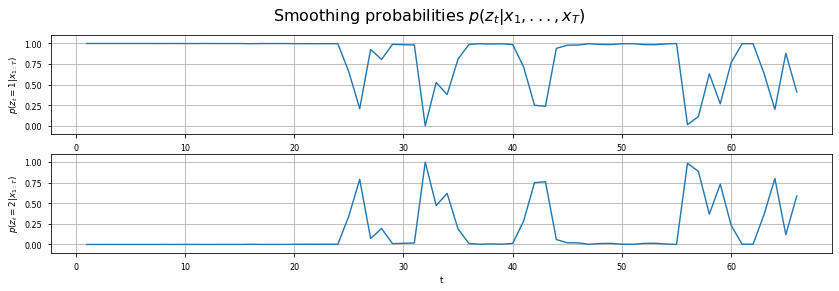

In [15]:
# ---------------------------------------------------------------------------- #
#     Do NOT change the contents of this cell. This is just for execution.     #
#   If you respected function signatures, this cell should run without changes #
# ---------------------------------------------------------------------------- #
# Compute emission (log) probabilities
Yc_train, Yc_test = clean_batch(Y_train), clean_batch(Y_test)
eps = emission(Y_train_idx, Yc_train)
M = comp_transition(Y_train_idx, Yc_train)
pi = np.array([1, 1e-9])

# Perform (log) alpha and beta recursions
alpha = alpha_recursion(Yc_train[0], M, eps, pi, context=excel_data.iloc[Y_train_idx[0]][CONTEXT_COLUMN])
beta = beta_recursion(Yc_train[0], M, eps, context=excel_data.iloc[Y_train_idx[0]][CONTEXT_COLUMN])

# Compute smoothing probabilities
gamma = smoothing(alpha, beta)

# Now we do the plot of the smoothing probability for each of the 4 states
plot_smoothing(gamma, time_limit=Yc_train[0].shape[0])

## Viterbi 

Implement Viterbi decoding.

In [16]:
def viterbi(Y, pi, M, eps, context):
    # initialization step
    vit = np.zeros((NUMBER_STATE, TIME_SERIES_LENGTH))
    backpointer = np.zeros((NUMBER_STATE, TIME_SERIES_LENGTH))
    for st in STATE:
        *obs, _ = Y.iloc[0]
        vit[st, 0] = log_product(log(pi[st]), log(emission_prob(eps, context, st, obs)))
        backpointer[st, 0] = None

    # recursion step
    for t, vars in Y.iloc[1:].iterrows():
        *obs, _ = vars
        for st in STATE:
            _c = [log_product(vit[pst, t-1], 
                              log_product(log(M[context][pst][st]), 
                                          log(emission_prob(eps, context, st, obs)))) for pst in STATE]
            vit[st, t] = max(_c)
            backpointer[st, t] = np.argmax(_c)
    
    # termination step
    best_path_prob = max(vit[:, t])
    best_state_ptr = np.argmax(vit[:, t])

    best_path = []
    while not math.isnan(best_state_ptr):
        best_state_ptr = int(best_state_ptr)
        best_path.append(best_state_ptr)
        best_state_ptr = backpointer[best_state_ptr, t]
        t -= 1
    best_path.reverse()

    return best_path, best_path_prob

Using the set of parameters learned with the EM algorithm on the **training** set, compute the most likely sequence of states for the **training** data with the Viterbi algorithm. Plot your results.

In [17]:
def plot_viterbi(predicted_path, expected_path):
    plt.figure(figsize=(28, 4))
    plt.suptitle('Predict Hidden State via Viterbi', fontsize=16)
    for i, ins in enumerate({'predicted': predicted_path, 'expected': expected_path}.items()):
        plt.subplot(2, 1, 1+i)
        plt.plot(ins[1], marker='o')
        plt.xticks(list(range(len(ins[1]))))
        plt.yticks(STATE)
        plt.ylim(-0.1, 1.1)
        plt.ylabel(ins[0])
        plt.grid(True)
    plt.xlabel('t')
    plt.show()

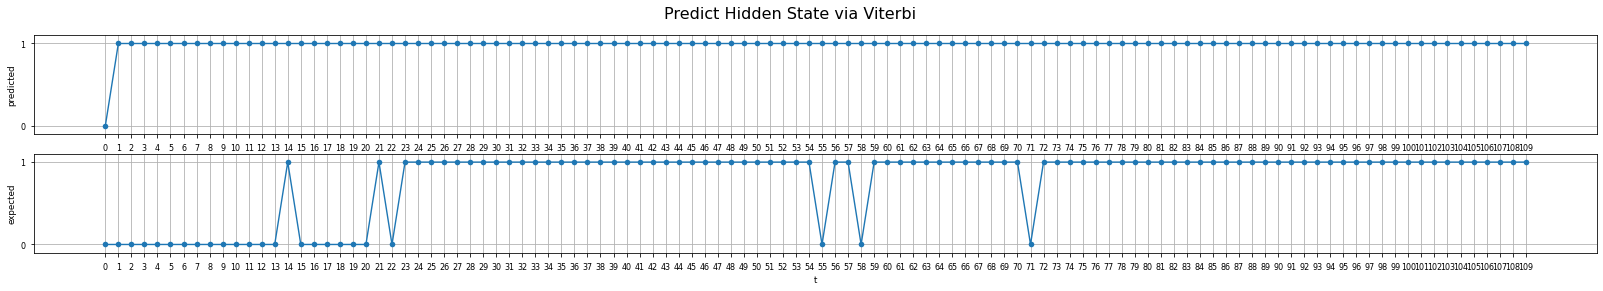

In [18]:
# Get one_hot_labels from Viterbi and turn them into 0, ..., K-1 "numeric" labels
Yc_test = clean_batch(Y_test)
best_path, best_path_prob = viterbi(Yc_test[0], pi, M, eps, context=excel_data.iloc[Y_test_idx[0]][CONTEXT_COLUMN])

plot_viterbi(predicted_path=best_path, expected_path=Yc_test[0].target.tolist())

# Training

In [ ]:
from itertools import combinations

pi = np.array([1, 1e-9])
Yc = clean_batch(Y)

for CONTEXT_COLUMN in ['c1', 'c2', 'c3', 'c4', 'c5', 'c6', 'c7', 'c8', 'c9', 'c10', 'c10.1', 'c12', 'c13', 'c14']:
    CONTEXT = list(set(excel_data[CONTEXT_COLUMN]))
    for length in range(1, 6):
        FEATUREs = combinations([0, 1, 2, 3, 4], length)
        for FEATURE in FEATUREs:
            overal_acc = 0
            for i in tqdm(range(len(Yc))):
                y_test_idx, y_test = i, Yc[i]
                Y_train_idx = [j for j in range(len(Yc)) if j!=i]
                Yc_train = [Yc[j] for j in range(len(Yc)) if j!=i]

                eps = emission(Y_train_idx, Yc_train)
                M = comp_transition(Y_train_idx, Yc_train)
                
                context=excel_data.iloc[i][CONTEXT_COLUMN]
                best_path, _ = viterbi(y_test, pi, M, eps, context)
                overal_acc += (accuracy_score(y_true=y_test.target.tolist(), y_pred=best_path) / len(Yc))

            print("Overal Accuracy: {} with features {} and context {}".format(overal_acc, FEATURE, CONTEXT_COLUMN))

  0%|          | 0/21 [00:00<?, ?it/s]

Overal Accuracy: 0.7770739340618693 with features (0,) and context c1


  0%|          | 0/21 [00:00<?, ?it/s]

Overal Accuracy: 0.3933297534256089 with features (1,) and context c1


  0%|          | 0/21 [00:00<?, ?it/s]

Overal Accuracy: 0.6212602382563674 with features (2,) and context c1


  0%|          | 0/21 [00:00<?, ?it/s]

Overal Accuracy: 0.6704217306202468 with features (3,) and context c1


  0%|          | 0/21 [00:00<?, ?it/s]

Overal Accuracy: 0.48065357074764437 with features (4,) and context c1


  0%|          | 0/21 [00:00<?, ?it/s]

Overal Accuracy: 0.7647819297168462 with features (0, 1) and context c1


  0%|          | 0/21 [00:00<?, ?it/s]

Overal Accuracy: 0.7645365038636195 with features (0, 2) and context c1


  0%|          | 0/21 [00:00<?, ?it/s]

Overal Accuracy: 0.7645597428211508 with features (0, 3) and context c1


  0%|          | 0/21 [00:00<?, ?it/s]

Overal Accuracy: 0.7781596164595599 with features (0, 4) and context c1


  0%|          | 0/21 [00:00<?, ?it/s]

Overal Accuracy: 0.5737741164226364 with features (1, 2) and context c1


  0%|          | 0/21 [00:00<?, ?it/s]

Overal Accuracy: 0.6441081741013153 with features (1, 3) and context c1


  0%|          | 0/21 [00:00<?, ?it/s]

Overal Accuracy: 0.5049484244443865 with features (1, 4) and context c1


  0%|          | 0/21 [00:00<?, ?it/s]

Overal Accuracy: 0.6545763986110514 with features (2, 3) and context c1


  0%|          | 0/21 [00:00<?, ?it/s]

Overal Accuracy: 0.6694233523391958 with features (2, 4) and context c1


  0%|          | 0/21 [00:00<?, ?it/s]

Overal Accuracy: 0.6847563342483064 with features (3, 4) and context c1


  0%|          | 0/21 [00:00<?, ?it/s]

Overal Accuracy: 0.7816708786681005 with features (0, 1, 2) and context c1


  0%|          | 0/21 [00:00<?, ?it/s]

Overal Accuracy: 0.778551781094526 with features (0, 1, 3) and context c1


  0%|          | 0/21 [00:00<?, ?it/s]

Overal Accuracy: 0.7709800874883921 with features (0, 1, 4) and context c1


  0%|          | 0/21 [00:00<?, ?it/s]

Overal Accuracy: 0.771449238913913 with features (0, 2, 3) and context c1


  0%|          | 0/21 [00:00<?, ?it/s]

Overal Accuracy: 0.7826939179311673 with features (0, 2, 4) and context c1


  0%|          | 0/21 [00:00<?, ?it/s]

Overal Accuracy: 0.7802713580705051 with features (0, 3, 4) and context c1


  0%|          | 0/21 [00:00<?, ?it/s]

Overal Accuracy: 0.6326339148690159 with features (1, 2, 3) and context c1


  0%|          | 0/21 [00:00<?, ?it/s]

Overal Accuracy: 0.6889904830060642 with features (1, 2, 4) and context c1


  0%|          | 0/21 [00:00<?, ?it/s]

Overal Accuracy: 0.6779000068039839 with features (1, 3, 4) and context c1


  0%|          | 0/21 [00:00<?, ?it/s]

Overal Accuracy: 0.7157453566608935 with features (2, 3, 4) and context c1


  0%|          | 0/21 [00:00<?, ?it/s]

Overal Accuracy: 0.7869548336139184 with features (0, 1, 2, 3) and context c1


  0%|          | 0/21 [00:00<?, ?it/s]

Overal Accuracy: 0.8056364647212853 with features (0, 1, 2, 4) and context c1


  0%|          | 0/21 [00:00<?, ?it/s]

Overal Accuracy: 0.7914108284892152 with features (0, 1, 3, 4) and context c1


  0%|          | 0/21 [00:00<?, ?it/s]

Overal Accuracy: 0.7771448339746069 with features (0, 2, 3, 4) and context c1


  0%|          | 0/21 [00:00<?, ?it/s]

Overal Accuracy: 0.6696739454810878 with features (1, 2, 3, 4) and context c1


  0%|          | 0/21 [00:00<?, ?it/s]

Overal Accuracy: 0.7793402367978212 with features (0, 1, 2, 3, 4) and context c1


  0%|          | 0/21 [00:00<?, ?it/s]

Overal Accuracy: 0.7268646670556604 with features (0,) and context c2


  0%|          | 0/21 [00:00<?, ?it/s]

Overal Accuracy: 0.4104393689149965 with features (1,) and context c2


  0%|          | 0/21 [00:00<?, ?it/s]

Overal Accuracy: 0.5400593309265627 with features (2,) and context c2


  0%|          | 0/21 [00:00<?, ?it/s]

Overal Accuracy: 0.6342934633749651 with features (3,) and context c2


  0%|          | 0/21 [00:00<?, ?it/s]

Overal Accuracy: 0.5401304773710847 with features (4,) and context c2


  0%|          | 0/21 [00:00<?, ?it/s]

Overal Accuracy: 0.7181715234055428 with features (0, 1) and context c2


  0%|          | 0/21 [00:00<?, ?it/s]

Overal Accuracy: 0.7263097679030592 with features (0, 2) and context c2


  0%|          | 0/21 [00:00<?, ?it/s]

Overal Accuracy: 0.7789269072536197 with features (0, 3) and context c2


  0%|          | 0/21 [00:00<?, ?it/s]

Overal Accuracy: 0.7292552001185507 with features (0, 4) and context c2


  0%|          | 0/21 [00:00<?, ?it/s]

Overal Accuracy: 0.5957240840682422 with features (1, 2) and context c2


  0%|          | 0/21 [00:00<?, ?it/s]

Overal Accuracy: 0.6383188776290056 with features (1, 3) and context c2


  0%|          | 0/21 [00:00<?, ?it/s]

Overal Accuracy: 0.5270480844306775 with features (1, 4) and context c2


  0%|          | 0/21 [00:00<?, ?it/s]

Overal Accuracy: 0.614004004050909 with features (2, 3) and context c2


  0%|          | 0/21 [00:00<?, ?it/s]

Overal Accuracy: 0.6270603137457887 with features (2, 4) and context c2


  0%|          | 0/21 [00:00<?, ?it/s]

Overal Accuracy: 0.6460260868767268 with features (3, 4) and context c2


  0%|          | 0/21 [00:00<?, ?it/s]

Overal Accuracy: 0.7514381726061485 with features (0, 1, 2) and context c2


  0%|          | 0/21 [00:00<?, ?it/s]

Overal Accuracy: 0.7647232944648064 with features (0, 1, 3) and context c2


  0%|          | 0/21 [00:00<?, ?it/s]

Overal Accuracy: 0.7324839661875012 with features (0, 1, 4) and context c2


  0%|          | 0/21 [00:00<?, ?it/s]

Overal Accuracy: 0.7473286483169481 with features (0, 2, 3) and context c2


  0%|          | 0/21 [00:00<?, ?it/s]

Overal Accuracy: 0.7214400634611698 with features (0, 2, 4) and context c2


  0%|          | 0/21 [00:00<?, ?it/s]

Overal Accuracy: 0.7499651659904751 with features (0, 3, 4) and context c2


  0%|          | 0/21 [00:00<?, ?it/s]

Overal Accuracy: 0.6233828632064435 with features (1, 2, 3) and context c2


  0%|          | 0/21 [00:00<?, ?it/s]

Overal Accuracy: 0.6379909647748405 with features (1, 2, 4) and context c2


  0%|          | 0/21 [00:00<?, ?it/s]

Overal Accuracy: 0.6577756259083372 with features (1, 3, 4) and context c2


  0%|          | 0/21 [00:00<?, ?it/s]

Overal Accuracy: 0.6568209687809285 with features (2, 3, 4) and context c2


  0%|          | 0/21 [00:00<?, ?it/s]

Overal Accuracy: 0.7477811831225241 with features (0, 1, 2, 3) and context c2


  0%|          | 0/21 [00:00<?, ?it/s]

Overal Accuracy: 0.7326646518942604 with features (0, 1, 2, 4) and context c2


  0%|          | 0/21 [00:00<?, ?it/s]

Overal Accuracy: 0.7466138511780682 with features (0, 1, 3, 4) and context c2


  0%|          | 0/21 [00:00<?, ?it/s]

Overal Accuracy: 0.766662878747138 with features (0, 2, 3, 4) and context c2


  0%|          | 0/21 [00:00<?, ?it/s]

Overal Accuracy: 0.6660518738248515 with features (1, 2, 3, 4) and context c2


  0%|          | 0/21 [00:00<?, ?it/s]

Overal Accuracy: 0.7552429184511784 with features (0, 1, 2, 3, 4) and context c2


  0%|          | 0/21 [00:00<?, ?it/s]

Overal Accuracy: 0.7574469958774019 with features (0,) and context c3


  0%|          | 0/21 [00:00<?, ?it/s]

Overal Accuracy: 0.5394689293963222 with features (1,) and context c3


  0%|          | 0/21 [00:00<?, ?it/s]

Overal Accuracy: 0.6383946647124888 with features (2,) and context c3


  0%|          | 0/21 [00:00<?, ?it/s]

Overal Accuracy: 0.666913787810706 with features (3,) and context c3


  0%|          | 0/21 [00:00<?, ?it/s]

Overal Accuracy: 0.48094021524854824 with features (4,) and context c3


  0%|          | 0/21 [00:00<?, ?it/s]

Overal Accuracy: 0.7867072529522643 with features (0, 1) and context c3


  0%|          | 0/21 [00:00<?, ?it/s]

Overal Accuracy: 0.761339750492859 with features (0, 2) and context c3


  0%|          | 0/21 [00:00<?, ?it/s]

Overal Accuracy: 0.7611219440720451 with features (0, 3) and context c3


  0%|          | 0/21 [00:00<?, ?it/s]

Overal Accuracy: 0.7704195041161418 with features (0, 4) and context c3


  0%|          | 0/21 [00:00<?, ?it/s]

Overal Accuracy: 0.6734684716667755 with features (1, 2) and context c3


  0%|          | 0/21 [00:00<?, ?it/s]

Overal Accuracy: 0.7279778750277309 with features (1, 3) and context c3


  0%|          | 0/21 [00:00<?, ?it/s]

Overal Accuracy: 0.6255753234787819 with features (1, 4) and context c3


  0%|          | 0/21 [00:00<?, ?it/s]

Overal Accuracy: 0.657311994428314 with features (2, 3) and context c3


  0%|          | 0/21 [00:00<?, ?it/s]

Overal Accuracy: 0.6866394166691514 with features (2, 4) and context c3


  0%|          | 0/21 [00:00<?, ?it/s]

Overal Accuracy: 0.6865253983382777 with features (3, 4) and context c3


  0%|          | 0/21 [00:00<?, ?it/s]

Overal Accuracy: 0.788631706014877 with features (0, 1, 2) and context c3


  0%|          | 0/21 [00:00<?, ?it/s]

Overal Accuracy: 0.7821686990780959 with features (0, 1, 3) and context c3


  0%|          | 0/21 [00:00<?, ?it/s]

Overal Accuracy: 0.8104380009825798 with features (0, 1, 4) and context c3


  0%|          | 0/21 [00:00<?, ?it/s]

Overal Accuracy: 0.7679293221396725 with features (0, 2, 3) and context c3


  0%|          | 0/21 [00:00<?, ?it/s]

Overal Accuracy: 0.7796585582879546 with features (0, 2, 4) and context c3


  0%|          | 0/21 [00:00<?, ?it/s]

Overal Accuracy: 0.7820612082178904 with features (0, 3, 4) and context c3


  0%|          | 0/21 [00:00<?, ?it/s]

Overal Accuracy: 0.6848698896926362 with features (1, 2, 3) and context c3


  0%|          | 0/21 [00:00<?, ?it/s]

Overal Accuracy: 0.7371483018903818 with features (1, 2, 4) and context c3


  0%|          | 0/21 [00:00<?, ?it/s]

Overal Accuracy: 0.7688229268026826 with features (1, 3, 4) and context c3


  0%|          | 0/21 [00:00<?, ?it/s]

Overal Accuracy: 0.6923823484389103 with features (2, 3, 4) and context c3


  0%|          | 0/21 [00:00<?, ?it/s]

Overal Accuracy: 0.7776014369775641 with features (0, 1, 2, 3) and context c3


  0%|          | 0/21 [00:00<?, ?it/s]

Overal Accuracy: 0.8083960452688232 with features (0, 1, 2, 4) and context c3


  0%|          | 0/21 [00:00<?, ?it/s]

Overal Accuracy: 0.803667592493684 with features (0, 1, 3, 4) and context c3


  0%|          | 0/21 [00:00<?, ?it/s]

Overal Accuracy: 0.789038404343617 with features (0, 2, 3, 4) and context c3


  0%|          | 0/21 [00:00<?, ?it/s]

Overal Accuracy: 0.7507919596594254 with features (1, 2, 3, 4) and context c3


  0%|          | 0/21 [00:00<?, ?it/s]

Overal Accuracy: 0.8021360212477768 with features (0, 1, 2, 3, 4) and context c3


  0%|          | 0/21 [00:00<?, ?it/s]

Overal Accuracy: 0.7399590996846549 with features (0,) and context c4


  0%|          | 0/21 [00:00<?, ?it/s]

Overal Accuracy: 0.4104069217711341 with features (1,) and context c4


  0%|          | 0/21 [00:00<?, ?it/s]

Overal Accuracy: 0.5750064364132835 with features (2,) and context c4


  0%|          | 0/21 [00:00<?, ?it/s]

Overal Accuracy: 0.6711620347000682 with features (3,) and context c4


  0%|          | 0/21 [00:00<?, ?it/s]

Overal Accuracy: 0.4789788540638861 with features (4,) and context c4


  0%|          | 0/21 [00:00<?, ?it/s]

Overal Accuracy: 0.7922833277055786 with features (0, 1) and context c4


  0%|          | 0/21 [00:00<?, ?it/s]

Overal Accuracy: 0.741694886687716 with features (0, 2) and context c4


  0%|          | 0/21 [00:00<?, ?it/s]

Overal Accuracy: 0.7460874935530517 with features (0, 3) and context c4


  0%|          | 0/21 [00:00<?, ?it/s]

Overal Accuracy: 0.7638046547572964 with features (0, 4) and context c4


  0%|          | 0/21 [00:00<?, ?it/s]

Overal Accuracy: 0.6075530799939861 with features (1, 2) and context c4


  0%|          | 0/21 [00:00<?, ?it/s]

Overal Accuracy: 0.6152435002046368 with features (1, 3) and context c4


  0%|          | 0/21 [00:00<?, ?it/s]

Overal Accuracy: 0.53612604712968 with features (1, 4) and context c4


  0%|          | 0/21 [00:00<?, ?it/s]

Overal Accuracy: 0.6400763315838223 with features (2, 3) and context c4


  0%|          | 0/21 [00:00<?, ?it/s]

Overal Accuracy: 0.6553128694425661 with features (2, 4) and context c4


  0%|          | 0/21 [00:00<?, ?it/s]

Overal Accuracy: 0.6912013125838603 with features (3, 4) and context c4


  0%|          | 0/21 [00:00<?, ?it/s]

Overal Accuracy: 0.7539468889474245 with features (0, 1, 2) and context c4


  0%|          | 0/21 [00:00<?, ?it/s]

Overal Accuracy: 0.7842065056358675 with features (0, 1, 3) and context c4


  0%|          | 0/21 [00:00<?, ?it/s]

Overal Accuracy: 0.8106276340010014 with features (0, 1, 4) and context c4


  0%|          | 0/21 [00:00<?, ?it/s]

Overal Accuracy: 0.7469618356530713 with features (0, 2, 3) and context c4


  0%|          | 0/21 [00:00<?, ?it/s]

Overal Accuracy: 0.7478617212171026 with features (0, 2, 4) and context c4


  0%|          | 0/21 [00:00<?, ?it/s]

Overal Accuracy: 0.7685466530156415 with features (0, 3, 4) and context c4


  0%|          | 0/21 [00:00<?, ?it/s]

Overal Accuracy: 0.6209720219323988 with features (1, 2, 3) and context c4


  0%|          | 0/21 [00:00<?, ?it/s]

Overal Accuracy: 0.6540355207543039 with features (1, 2, 4) and context c4


  0%|          | 0/21 [00:00<?, ?it/s]

Overal Accuracy: 0.6617238322221458 with features (1, 3, 4) and context c4


  0%|          | 0/21 [00:00<?, ?it/s]

Overal Accuracy: 0.6589664363091292 with features (2, 3, 4) and context c4


  0%|          | 0/21 [00:00<?, ?it/s]

Overal Accuracy: 0.7626784314626998 with features (0, 1, 2, 3) and context c4


  0%|          | 0/21 [00:00<?, ?it/s]

Overal Accuracy: 0.7633542093940014 with features (0, 1, 2, 4) and context c4


  0%|          | 0/21 [00:00<?, ?it/s]

Overal Accuracy: 0.7898494624464732 with features (0, 1, 3, 4) and context c4


  0%|          | 0/21 [00:00<?, ?it/s]

Overal Accuracy: 0.7500159441060431 with features (0, 2, 3, 4) and context c4


  0%|          | 0/21 [00:00<?, ?it/s]

Overal Accuracy: 0.6525044428055877 with features (1, 2, 3, 4) and context c4


  0%|          | 0/21 [00:00<?, ?it/s]

Overal Accuracy: 0.752936510077363 with features (0, 1, 2, 3, 4) and context c4


  0%|          | 0/21 [00:00<?, ?it/s]

Overal Accuracy: 0.7601881944002595 with features (0,) and context c5


  0%|          | 0/21 [00:00<?, ?it/s]

Overal Accuracy: 0.47708131265781845 with features (1,) and context c5


  0%|          | 0/21 [00:00<?, ?it/s]

Overal Accuracy: 0.641745655558309 with features (2,) and context c5


  0%|          | 0/21 [00:00<?, ?it/s]

Overal Accuracy: 0.6482469586257014 with features (3,) and context c5


  0%|          | 0/21 [00:00<?, ?it/s]

Overal Accuracy: 0.5303839265761723 with features (4,) and context c5


  0%|          | 0/21 [00:00<?, ?it/s]

Overal Accuracy: 0.7665266461765066 with features (0, 1) and context c5


  0%|          | 0/21 [00:00<?, ?it/s]

Overal Accuracy: 0.7678512540195832 with features (0, 2) and context c5


  0%|          | 0/21 [00:00<?, ?it/s]

Overal Accuracy: 0.7662863868795251 with features (0, 3) and context c5


  0%|          | 0/21 [00:00<?, ?it/s]

Overal Accuracy: 0.7641281078281312 with features (0, 4) and context c5


  0%|          | 0/21 [00:00<?, ?it/s]

Overal Accuracy: 0.5744973506692311 with features (1, 2) and context c5


  0%|          | 0/21 [00:00<?, ?it/s]

Overal Accuracy: 0.608948726287423 with features (1, 3) and context c5


  0%|          | 0/21 [00:00<?, ?it/s]

Overal Accuracy: 0.569353872284395 with features (1, 4) and context c5


  0%|          | 0/21 [00:00<?, ?it/s]

Overal Accuracy: 0.6284566689646227 with features (2, 3) and context c5


  0%|          | 0/21 [00:00<?, ?it/s]

Overal Accuracy: 0.6727968580086549 with features (2, 4) and context c5


  0%|          | 0/21 [00:00<?, ?it/s]

Overal Accuracy: 0.673892334724336 with features (3, 4) and context c5


  0%|          | 0/21 [00:00<?, ?it/s]

Overal Accuracy: 0.7695061482788285 with features (0, 1, 2) and context c5


  0%|          | 0/21 [00:00<?, ?it/s]

Overal Accuracy: 0.7715575887700883 with features (0, 1, 3) and context c5


  0%|          | 0/21 [00:00<?, ?it/s]

Overal Accuracy: 0.7776012018609584 with features (0, 1, 4) and context c5


  0%|          | 0/21 [00:00<?, ?it/s]

Overal Accuracy: 0.775067255775262 with features (0, 2, 3) and context c5


  0%|          | 0/21 [00:00<?, ?it/s]

Overal Accuracy: 0.7756285259849993 with features (0, 2, 4) and context c5


  0%|          | 0/21 [00:00<?, ?it/s]

Overal Accuracy: 0.7811191990707511 with features (0, 3, 4) and context c5


  0%|          | 0/21 [00:00<?, ?it/s]

Overal Accuracy: 0.6221904807261505 with features (1, 2, 3) and context c5


  0%|          | 0/21 [00:00<?, ?it/s]

Overal Accuracy: 0.6560475871170668 with features (1, 2, 4) and context c5


  0%|          | 0/21 [00:00<?, ?it/s]

Overal Accuracy: 0.6784832391276469 with features (1, 3, 4) and context c5


  0%|          | 0/21 [00:00<?, ?it/s]

Overal Accuracy: 0.6929435226662652 with features (2, 3, 4) and context c5


  0%|          | 0/21 [00:00<?, ?it/s]

Overal Accuracy: 0.7706948147158673 with features (0, 1, 2, 3) and context c5


  0%|          | 0/21 [00:00<?, ?it/s]

Overal Accuracy: 0.7705363317671354 with features (0, 1, 2, 4) and context c5


  0%|          | 0/21 [00:00<?, ?it/s]

Overal Accuracy: 0.7800995480977548 with features (0, 1, 3, 4) and context c5


  0%|          | 0/21 [00:00<?, ?it/s]

Overal Accuracy: 0.7864122704054802 with features (0, 2, 3, 4) and context c5


  0%|          | 0/21 [00:00<?, ?it/s]

Overal Accuracy: 0.6938045946558888 with features (1, 2, 3, 4) and context c5


  0%|          | 0/21 [00:00<?, ?it/s]

Overal Accuracy: 0.766990847737304 with features (0, 1, 2, 3, 4) and context c5


  0%|          | 0/21 [00:00<?, ?it/s]

Overal Accuracy: 0.7633162120296645 with features (0,) and context c6


  0%|          | 0/21 [00:00<?, ?it/s]

Overal Accuracy: 0.3974829351826263 with features (1,) and context c6


  0%|          | 0/21 [00:00<?, ?it/s]

Overal Accuracy: 0.6329365138423636 with features (2,) and context c6


  0%|          | 0/21 [00:00<?, ?it/s]

Overal Accuracy: 0.647935278908584 with features (3,) and context c6


  0%|          | 0/21 [00:00<?, ?it/s]

Overal Accuracy: 0.4761551867947966 with features (4,) and context c6


  0%|          | 0/21 [00:00<?, ?it/s]

Overal Accuracy: 0.7583737732241359 with features (0, 1) and context c6


  0%|          | 0/21 [00:00<?, ?it/s]

Overal Accuracy: 0.771238652851748 with features (0, 2) and context c6


  0%|          | 0/21 [00:00<?, ?it/s]

Overal Accuracy: 0.7726981693538019 with features (0, 3) and context c6


  0%|          | 0/21 [00:00<?, ?it/s]

Overal Accuracy: 0.7689369728593062 with features (0, 4) and context c6


  0%|          | 0/21 [00:00<?, ?it/s]

Overal Accuracy: 0.6255661446233151 with features (1, 2) and context c6


  0%|          | 0/21 [00:00<?, ?it/s]

Overal Accuracy: 0.6762531408870655 with features (1, 3) and context c6


  0%|          | 0/21 [00:00<?, ?it/s]

Overal Accuracy: 0.5318738339942188 with features (1, 4) and context c6


  0%|          | 0/21 [00:00<?, ?it/s]

Overal Accuracy: 0.6353133294971149 with features (2, 3) and context c6


  0%|          | 0/21 [00:00<?, ?it/s]

Overal Accuracy: 0.6959458393977722 with features (2, 4) and context c6


  0%|          | 0/21 [00:00<?, ?it/s]

Overal Accuracy: 0.7168955304606379 with features (3, 4) and context c6


  0%|          | 0/21 [00:00<?, ?it/s]

Overal Accuracy: 0.7717044478727686 with features (0, 1, 2) and context c6


  0%|          | 0/21 [00:00<?, ?it/s]

Overal Accuracy: 0.7887222105515372 with features (0, 1, 3) and context c6


  0%|          | 0/21 [00:00<?, ?it/s]

Overal Accuracy: 0.7648058280825782 with features (0, 1, 4) and context c6


  0%|          | 0/21 [00:00<?, ?it/s]

Overal Accuracy: 0.7844712454046239 with features (0, 2, 3) and context c6


  0%|          | 0/21 [00:00<?, ?it/s]

Overal Accuracy: 0.779117547978703 with features (0, 2, 4) and context c6


  0%|          | 0/21 [00:00<?, ?it/s]

Overal Accuracy: 0.7812961157635235 with features (0, 3, 4) and context c6


  0%|          | 0/21 [00:00<?, ?it/s]

Overal Accuracy: 0.6604939233624314 with features (1, 2, 3) and context c6


  0%|          | 0/21 [00:00<?, ?it/s]

Overal Accuracy: 0.7008552434030547 with features (1, 2, 4) and context c6


  0%|          | 0/21 [00:00<?, ?it/s]

Overal Accuracy: 0.7171882740773469 with features (1, 3, 4) and context c6


  0%|          | 0/21 [00:00<?, ?it/s]

Overal Accuracy: 0.71701517807696 with features (2, 3, 4) and context c6


  0%|          | 0/21 [00:00<?, ?it/s]

Overal Accuracy: 0.7736113566708447 with features (0, 1, 2, 3) and context c6


  0%|          | 0/21 [00:00<?, ?it/s]

Overal Accuracy: 0.8018359148203712 with features (0, 1, 2, 4) and context c6


  0%|          | 0/21 [00:00<?, ?it/s]

Overal Accuracy: 0.7975233163567292 with features (0, 1, 3, 4) and context c6


  0%|          | 0/21 [00:00<?, ?it/s]

Overal Accuracy: 0.7802808645745967 with features (0, 2, 3, 4) and context c6


  0%|          | 0/21 [00:00<?, ?it/s]

Overal Accuracy: 0.7117948796685639 with features (1, 2, 3, 4) and context c6


  0%|          | 0/21 [00:00<?, ?it/s]

Overal Accuracy: 0.787617146293816 with features (0, 1, 2, 3, 4) and context c6


  0%|          | 0/21 [00:00<?, ?it/s]

Overal Accuracy: 0.7344163054882992 with features (0,) and context c7


  0%|          | 0/21 [00:00<?, ?it/s]

Overal Accuracy: 0.5913430313524486 with features (1,) and context c7


  0%|          | 0/21 [00:00<?, ?it/s]

Overal Accuracy: 0.625598969610612 with features (2,) and context c7


  0%|          | 0/21 [00:00<?, ?it/s]

Overal Accuracy: 0.6552895449350201 with features (3,) and context c7


  0%|          | 0/21 [00:00<?, ?it/s]

Overal Accuracy: 0.5314278852303291 with features (4,) and context c7


  0%|          | 0/21 [00:00<?, ?it/s]

Overal Accuracy: 0.7802408026660316 with features (0, 1) and context c7


  0%|          | 0/21 [00:00<?, ?it/s]

Overal Accuracy: 0.7367854632664886 with features (0, 2) and context c7


  0%|          | 0/21 [00:00<?, ?it/s]

Overal Accuracy: 0.734182547180981 with features (0, 3) and context c7


  0%|          | 0/21 [00:00<?, ?it/s]

Overal Accuracy: 0.7554999922466522 with features (0, 4) and context c7


  0%|          | 0/21 [00:00<?, ?it/s]

Overal Accuracy: 0.6758779871104973 with features (1, 2) and context c7


  0%|          | 0/21 [00:00<?, ?it/s]

Overal Accuracy: 0.6867482153768082 with features (1, 3) and context c7


  0%|          | 0/21 [00:00<?, ?it/s]

Overal Accuracy: 0.6347548760537403 with features (1, 4) and context c7


  0%|          | 0/21 [00:00<?, ?it/s]

Overal Accuracy: 0.6236023979080154 with features (2, 3) and context c7


  0%|          | 0/21 [00:00<?, ?it/s]

Overal Accuracy: 0.7042168296835859 with features (2, 4) and context c7


  0%|          | 0/21 [00:00<?, ?it/s]

Overal Accuracy: 0.6926737071784583 with features (3, 4) and context c7


  0%|          | 0/21 [00:00<?, ?it/s]

Overal Accuracy: 0.7948650581064711 with features (0, 1, 2) and context c7


  0%|          | 0/21 [00:00<?, ?it/s]

Overal Accuracy: 0.8140053934101462 with features (0, 1, 3) and context c7


  0%|          | 0/21 [00:00<?, ?it/s]

Overal Accuracy: 0.7939892481511307 with features (0, 1, 4) and context c7


  0%|          | 0/21 [00:00<?, ?it/s]

Overal Accuracy: 0.7538691083691472 with features (0, 2, 3) and context c7


  0%|          | 0/21 [00:00<?, ?it/s]

Overal Accuracy: 0.7510695458831556 with features (0, 2, 4) and context c7


  0%|          | 0/21 [00:00<?, ?it/s]

Overal Accuracy: 0.756627767205301 with features (0, 3, 4) and context c7


  0%|          | 0/21 [00:00<?, ?it/s]

Overal Accuracy: 0.6921087254279813 with features (1, 2, 3) and context c7


  0%|          | 0/21 [00:00<?, ?it/s]

Overal Accuracy: 0.7062323751911447 with features (1, 2, 4) and context c7


  0%|          | 0/21 [00:00<?, ?it/s]

Overal Accuracy: 0.7060235122028314 with features (1, 3, 4) and context c7


  0%|          | 0/21 [00:00<?, ?it/s]

Overal Accuracy: 0.6877139219461172 with features (2, 3, 4) and context c7


  0%|          | 0/21 [00:00<?, ?it/s]

Overal Accuracy: 0.8041286326931532 with features (0, 1, 2, 3) and context c7


  0%|          | 0/21 [00:00<?, ?it/s]

Overal Accuracy: 0.80146537073607 with features (0, 1, 2, 4) and context c7


  0%|          | 0/21 [00:00<?, ?it/s]

Overal Accuracy: 0.820180004844555 with features (0, 1, 3, 4) and context c7


  0%|          | 0/21 [00:00<?, ?it/s]

Overal Accuracy: 0.7625446890239098 with features (0, 2, 3, 4) and context c7


  0%|          | 0/21 [00:00<?, ?it/s]

Overal Accuracy: 0.7390313867081766 with features (1, 2, 3, 4) and context c7


  0%|          | 0/21 [00:00<?, ?it/s]

Overal Accuracy: 0.8056291915826761 with features (0, 1, 2, 3, 4) and context c7


  0%|          | 0/21 [00:00<?, ?it/s]

Overal Accuracy: 0.7646972173143272 with features (0,) and context c8


  0%|          | 0/21 [00:00<?, ?it/s]

Overal Accuracy: 0.4076678281014434 with features (1,) and context c8


  0%|          | 0/21 [00:00<?, ?it/s]

Overal Accuracy: 0.5905884501911504 with features (2,) and context c8


  0%|          | 0/21 [00:00<?, ?it/s]

Overal Accuracy: 0.6701367584367646 with features (3,) and context c8


  0%|          | 0/21 [00:00<?, ?it/s]

Overal Accuracy: 0.4841717456943907 with features (4,) and context c8


  0%|          | 0/21 [00:00<?, ?it/s]

Overal Accuracy: 0.7712399807975951 with features (0, 1) and context c8


  0%|          | 0/21 [00:00<?, ?it/s]

Overal Accuracy: 0.7668362778920387 with features (0, 2) and context c8


  0%|          | 0/21 [00:00<?, ?it/s]

Overal Accuracy: 0.7731395814079467 with features (0, 3) and context c8


  0%|          | 0/21 [00:00<?, ?it/s]

Overal Accuracy: 0.7794570717872829 with features (0, 4) and context c8


  0%|          | 0/21 [00:00<?, ?it/s]

Overal Accuracy: 0.6010626237644164 with features (1, 2) and context c8


  0%|          | 0/21 [00:00<?, ?it/s]

Overal Accuracy: 0.6257899772281731 with features (1, 3) and context c8


  0%|          | 0/21 [00:00<?, ?it/s]

Overal Accuracy: 0.5242918406081093 with features (1, 4) and context c8


  0%|          | 0/21 [00:00<?, ?it/s]

Overal Accuracy: 0.6268666676782476 with features (2, 3) and context c8


  0%|          | 0/21 [00:00<?, ?it/s]

Overal Accuracy: 0.6788062486369636 with features (2, 4) and context c8


  0%|          | 0/21 [00:00<?, ?it/s]

Overal Accuracy: 0.6685749928170528 with features (3, 4) and context c8


  0%|          | 0/21 [00:00<?, ?it/s]

Overal Accuracy: 0.7691705087792585 with features (0, 1, 2) and context c8


  0%|          | 0/21 [00:00<?, ?it/s]

Overal Accuracy: 0.7719772968793709 with features (0, 1, 3) and context c8


  0%|          | 0/21 [00:00<?, ?it/s]

Overal Accuracy: 0.7872669176261209 with features (0, 1, 4) and context c8


  0%|          | 0/21 [00:00<?, ?it/s]

Overal Accuracy: 0.7681039132618854 with features (0, 2, 3) and context c8


  0%|          | 0/21 [00:00<?, ?it/s]

Overal Accuracy: 0.7836003642097963 with features (0, 2, 4) and context c8


  0%|          | 0/21 [00:00<?, ?it/s]

Overal Accuracy: 0.7732163072896114 with features (0, 3, 4) and context c8


  0%|          | 0/21 [00:00<?, ?it/s]

Overal Accuracy: 0.6373113147294067 with features (1, 2, 3) and context c8


  0%|          | 0/21 [00:00<?, ?it/s]

Overal Accuracy: 0.6789793570217465 with features (1, 2, 4) and context c8


  0%|          | 0/21 [00:00<?, ?it/s]

Overal Accuracy: 0.6901335243972538 with features (1, 3, 4) and context c8


  0%|          | 0/21 [00:00<?, ?it/s]

Overal Accuracy: 0.6917151029104055 with features (2, 3, 4) and context c8


  0%|          | 0/21 [00:00<?, ?it/s]

Overal Accuracy: 0.7657247338031395 with features (0, 1, 2, 3) and context c8


  0%|          | 0/21 [00:00<?, ?it/s]

Overal Accuracy: 0.7856615612236153 with features (0, 1, 2, 4) and context c8


  0%|          | 0/21 [00:00<?, ?it/s]

Overal Accuracy: 0.7817075963421201 with features (0, 1, 3, 4) and context c8


  0%|          | 0/21 [00:00<?, ?it/s]

Overal Accuracy: 0.7809570592049232 with features (0, 2, 3, 4) and context c8


  0%|          | 0/21 [00:00<?, ?it/s]

Overal Accuracy: 0.7026034091372537 with features (1, 2, 3, 4) and context c8


  0%|          | 0/21 [00:00<?, ?it/s]

Overal Accuracy: 0.7892784469698414 with features (0, 1, 2, 3, 4) and context c8


  0%|          | 0/21 [00:00<?, ?it/s]

Overal Accuracy: 0.7393546991172545 with features (0,) and context c9


  0%|          | 0/21 [00:00<?, ?it/s]

Overal Accuracy: 0.45059681479510333 with features (1,) and context c9


  0%|          | 0/21 [00:00<?, ?it/s]

Overal Accuracy: 0.564076841970294 with features (2,) and context c9


  0%|          | 0/21 [00:00<?, ?it/s]

Overal Accuracy: 0.6648942349961078 with features (3,) and context c9


  0%|          | 0/21 [00:00<?, ?it/s]

Overal Accuracy: 0.481864856949889 with features (4,) and context c9


  0%|          | 0/21 [00:00<?, ?it/s]

Overal Accuracy: 0.7815308774574187 with features (0, 1) and context c9


  0%|          | 0/21 [00:00<?, ?it/s]

Overal Accuracy: 0.7392597775261158 with features (0, 2) and context c9


  0%|          | 0/21 [00:00<?, ?it/s]

Overal Accuracy: 0.7397862753591308 with features (0, 3) and context c9


  0%|          | 0/21 [00:00<?, ?it/s]

Overal Accuracy: 0.7610319182763903 with features (0, 4) and context c9


  0%|          | 0/21 [00:00<?, ?it/s]

Overal Accuracy: 0.5750374379585403 with features (1, 2) and context c9


  0%|          | 0/21 [00:00<?, ?it/s]

Overal Accuracy: 0.5991787062626595 with features (1, 3) and context c9


  0%|          | 0/21 [00:00<?, ?it/s]

Overal Accuracy: 0.5430312664821723 with features (1, 4) and context c9


  0%|          | 0/21 [00:00<?, ?it/s]

Overal Accuracy: 0.6244608528055121 with features (2, 3) and context c9


  0%|          | 0/21 [00:00<?, ?it/s]

Overal Accuracy: 0.6997037158251838 with features (2, 4) and context c9


  0%|          | 0/21 [00:00<?, ?it/s]

Overal Accuracy: 0.6966425342684253 with features (3, 4) and context c9


  0%|          | 0/21 [00:00<?, ?it/s]

Overal Accuracy: 0.7824934759593574 with features (0, 1, 2) and context c9


  0%|          | 0/21 [00:00<?, ?it/s]

Overal Accuracy: 0.7804506451675138 with features (0, 1, 3) and context c9


  0%|          | 0/21 [00:00<?, ?it/s]

Overal Accuracy: 0.8009867537119817 with features (0, 1, 4) and context c9


  0%|          | 0/21 [00:00<?, ?it/s]

Overal Accuracy: 0.7491381065170629 with features (0, 2, 3) and context c9


  0%|          | 0/21 [00:00<?, ?it/s]

Overal Accuracy: 0.7598832580668498 with features (0, 2, 4) and context c9


  0%|          | 0/21 [00:00<?, ?it/s]

Overal Accuracy: 0.7650709070714219 with features (0, 3, 4) and context c9


  0%|          | 0/21 [00:00<?, ?it/s]

Overal Accuracy: 0.6016142356580246 with features (1, 2, 3) and context c9


  0%|          | 0/21 [00:00<?, ?it/s]

Overal Accuracy: 0.6794558821360376 with features (1, 2, 4) and context c9


  0%|          | 0/21 [00:00<?, ?it/s]

Overal Accuracy: 0.6795930694241383 with features (1, 3, 4) and context c9


  0%|          | 0/21 [00:00<?, ?it/s]

Overal Accuracy: 0.690701347731126 with features (2, 3, 4) and context c9


  0%|          | 0/21 [00:00<?, ?it/s]

Overal Accuracy: 0.764400544008606 with features (0, 1, 2, 3) and context c9


  0%|          | 0/21 [00:00<?, ?it/s]

Overal Accuracy: 0.7948748741953303 with features (0, 1, 2, 4) and context c9


  0%|          | 0/21 [00:00<?, ?it/s]

Overal Accuracy: 0.7999224462752812 with features (0, 1, 3, 4) and context c9


  0%|          | 0/21 [00:00<?, ?it/s]

Overal Accuracy: 0.760306969591838 with features (0, 2, 3, 4) and context c9


  0%|          | 0/21 [00:00<?, ?it/s]

Overal Accuracy: 0.6856797393191661 with features (1, 2, 3, 4) and context c9


  0%|          | 0/21 [00:00<?, ?it/s]

Overal Accuracy: 0.7844681081246377 with features (0, 1, 2, 3, 4) and context c9


  0%|          | 0/21 [00:00<?, ?it/s]

Overal Accuracy: 0.7501359476982565 with features (0,) and context c10


  0%|          | 0/21 [00:00<?, ?it/s]

Overal Accuracy: 0.43570521849105487 with features (1,) and context c10


  0%|          | 0/21 [00:00<?, ?it/s]

Overal Accuracy: 0.5959795813321551 with features (2,) and context c10


  0%|          | 0/21 [00:00<?, ?it/s]

Overal Accuracy: 0.6248195543443227 with features (3,) and context c10


  0%|          | 0/21 [00:00<?, ?it/s]

Overal Accuracy: 0.5031828185592692 with features (4,) and context c10


  0%|          | 0/21 [00:00<?, ?it/s]

Overal Accuracy: 0.7466203827634057 with features (0, 1) and context c10


  0%|          | 0/21 [00:00<?, ?it/s]

Overal Accuracy: 0.7559684777627007 with features (0, 2) and context c10


  0%|          | 0/21 [00:00<?, ?it/s]

Overal Accuracy: 0.7683261056471129 with features (0, 3) and context c10


  0%|          | 0/21 [00:00<?, ?it/s]

Overal Accuracy: 0.784369134472888 with features (0, 4) and context c10


  0%|          | 0/21 [00:00<?, ?it/s]

Overal Accuracy: 0.586055296673591 with features (1, 2) and context c10


  0%|          | 0/21 [00:00<?, ?it/s]

Overal Accuracy: 0.5788833928787481 with features (1, 3) and context c10


  0%|          | 0/21 [00:00<?, ?it/s]

Overal Accuracy: 0.5099684325961782 with features (1, 4) and context c10


  0%|          | 0/21 [00:00<?, ?it/s]

Overal Accuracy: 0.6218430080158658 with features (2, 3) and context c10


  0%|          | 0/21 [00:00<?, ?it/s]

Overal Accuracy: 0.6829366730589433 with features (2, 4) and context c10


  0%|          | 0/21 [00:00<?, ?it/s]

Overal Accuracy: 0.6741419391662499 with features (3, 4) and context c10


  0%|          | 0/21 [00:00<?, ?it/s]

Overal Accuracy: 0.7469826438699751 with features (0, 1, 2) and context c10


  0%|          | 0/21 [00:00<?, ?it/s]

Overal Accuracy: 0.7742009887663553 with features (0, 1, 3) and context c10


  0%|          | 0/21 [00:00<?, ?it/s]

Overal Accuracy: 0.7840729434547566 with features (0, 1, 4) and context c10


  0%|          | 0/21 [00:00<?, ?it/s]

Overal Accuracy: 0.7752697268471589 with features (0, 2, 3) and context c10


  0%|          | 0/21 [00:00<?, ?it/s]

Overal Accuracy: 0.7915847093899927 with features (0, 2, 4) and context c10


  0%|          | 0/21 [00:00<?, ?it/s]

Overal Accuracy: 0.7920137347102809 with features (0, 3, 4) and context c10


  0%|          | 0/21 [00:00<?, ?it/s]

Overal Accuracy: 0.5823131445409305 with features (1, 2, 3) and context c10


  0%|          | 0/21 [00:00<?, ?it/s]

Overal Accuracy: 0.6494512697421033 with features (1, 2, 4) and context c10


  0%|          | 0/21 [00:00<?, ?it/s]

Overal Accuracy: 0.6497771861427067 with features (1, 3, 4) and context c10


  0%|          | 0/21 [00:00<?, ?it/s]

Overal Accuracy: 0.6750801766696363 with features (2, 3, 4) and context c10


  0%|          | 0/21 [00:00<?, ?it/s]

Overal Accuracy: 0.7705596353463938 with features (0, 1, 2, 3) and context c10


  0%|          | 0/21 [00:00<?, ?it/s]

Overal Accuracy: 0.7861630641939784 with features (0, 1, 2, 4) and context c10


  0%|          | 0/21 [00:00<?, ?it/s]

Overal Accuracy: 0.7930914559618145 with features (0, 1, 3, 4) and context c10


  0%|          | 0/21 [00:00<?, ?it/s]

Overal Accuracy: 0.7974411940529385 with features (0, 2, 3, 4) and context c10


  0%|          | 0/21 [00:00<?, ?it/s]

Overal Accuracy: 0.6725670117106286 with features (1, 2, 3, 4) and context c10


  0%|          | 0/21 [00:00<?, ?it/s]

Overal Accuracy: 0.7794451448806238 with features (0, 1, 2, 3, 4) and context c10


  0%|          | 0/21 [00:00<?, ?it/s]

Overal Accuracy: 0.7497780349331857 with features (0,) and context c10.1


  0%|          | 0/21 [00:00<?, ?it/s]

Overal Accuracy: 0.5315105052676908 with features (1,) and context c10.1


  0%|          | 0/21 [00:00<?, ?it/s]

Overal Accuracy: 0.5951745705008856 with features (2,) and context c10.1


  0%|          | 0/21 [00:00<?, ?it/s]

Overal Accuracy: 0.6682095057885891 with features (3,) and context c10.1


  0%|          | 0/21 [00:00<?, ?it/s]

Overal Accuracy: 0.48306272740241785 with features (4,) and context c10.1


  0%|          | 0/21 [00:00<?, ?it/s]

Overal Accuracy: 0.7743935810433018 with features (0, 1) and context c10.1


  0%|          | 0/21 [00:00<?, ?it/s]

Overal Accuracy: 0.7523007685912813 with features (0, 2) and context c10.1


  0%|          | 0/21 [00:00<?, ?it/s]

Overal Accuracy: 0.7554837153518396 with features (0, 3) and context c10.1


  0%|          | 0/21 [00:00<?, ?it/s]

Overal Accuracy: 0.7567427198349344 with features (0, 4) and context c10.1


  0%|          | 0/21 [00:00<?, ?it/s]

Overal Accuracy: 0.5989214812863806 with features (1, 2) and context c10.1


  0%|          | 0/21 [00:00<?, ?it/s]

Overal Accuracy: 0.6400347595675875 with features (1, 3) and context c10.1


  0%|          | 0/21 [00:00<?, ?it/s]

Overal Accuracy: 0.6045632887616375 with features (1, 4) and context c10.1


  0%|          | 0/21 [00:00<?, ?it/s]

Overal Accuracy: 0.631621200067671 with features (2, 3) and context c10.1


  0%|          | 0/21 [00:00<?, ?it/s]

Overal Accuracy: 0.6901269327231019 with features (2, 4) and context c10.1


  0%|          | 0/21 [00:00<?, ?it/s]

Overal Accuracy: 0.6983370565086556 with features (3, 4) and context c10.1


  0%|          | 0/21 [00:00<?, ?it/s]

Overal Accuracy: 0.7798099423999333 with features (0, 1, 2) and context c10.1


  0%|          | 0/21 [00:00<?, ?it/s]

Overal Accuracy: 0.7838343479617575 with features (0, 1, 3) and context c10.1


  0%|          | 0/21 [00:00<?, ?it/s]

Overal Accuracy: 0.7516214243617383 with features (0, 1, 4) and context c10.1


  0%|          | 0/21 [00:00<?, ?it/s]

Overal Accuracy: 0.7587526002888592 with features (0, 2, 3) and context c10.1


  0%|          | 0/21 [00:00<?, ?it/s]

Overal Accuracy: 0.7617778967709183 with features (0, 2, 4) and context c10.1


  0%|          | 0/21 [00:00<?, ?it/s]

Overal Accuracy: 0.764492031796717 with features (0, 3, 4) and context c10.1


  0%|          | 0/21 [00:00<?, ?it/s]

Overal Accuracy: 0.6292017076810456 with features (1, 2, 3) and context c10.1


  0%|          | 0/21 [00:00<?, ?it/s]

Overal Accuracy: 0.7070446682234656 with features (1, 2, 4) and context c10.1


  0%|          | 0/21 [00:00<?, ?it/s]

Overal Accuracy: 0.6900305805458823 with features (1, 3, 4) and context c10.1


  0%|          | 0/21 [00:00<?, ?it/s]

Overal Accuracy: 0.6978392480500681 with features (2, 3, 4) and context c10.1


  0%|          | 0/21 [00:00<?, ?it/s]

Overal Accuracy: 0.7727811636674212 with features (0, 1, 2, 3) and context c10.1


  0%|          | 0/21 [00:00<?, ?it/s]

Overal Accuracy: 0.7870071856240489 with features (0, 1, 2, 4) and context c10.1


  0%|          | 0/21 [00:00<?, ?it/s]

Overal Accuracy: 0.7982883812708234 with features (0, 1, 3, 4) and context c10.1


  0%|          | 0/21 [00:00<?, ?it/s]

Overal Accuracy: 0.768529373138969 with features (0, 2, 3, 4) and context c10.1


  0%|          | 0/21 [00:00<?, ?it/s]

Overal Accuracy: 0.7154914573086967 with features (1, 2, 3, 4) and context c10.1


  0%|          | 0/21 [00:00<?, ?it/s]

Overal Accuracy: 0.774540414255312 with features (0, 1, 2, 3, 4) and context c10.1


  0%|          | 0/21 [00:00<?, ?it/s]

Overal Accuracy: 0.8011855036531053 with features (0,) and context c12


  0%|          | 0/21 [00:00<?, ?it/s]

Overal Accuracy: 0.42498279896984964 with features (1,) and context c12


  0%|          | 0/21 [00:00<?, ?it/s]

Overal Accuracy: 0.599019360521214 with features (2,) and context c12


  0%|          | 0/21 [00:00<?, ?it/s]

Overal Accuracy: 0.6393934664667139 with features (3,) and context c12


  0%|          | 0/21 [00:00<?, ?it/s]

Overal Accuracy: 0.5278768119836746 with features (4,) and context c12


  0%|          | 0/21 [00:00<?, ?it/s]

Overal Accuracy: 0.7694520982262202 with features (0, 1) and context c12


  0%|          | 0/21 [00:00<?, ?it/s]

Overal Accuracy: 0.8019835966730506 with features (0, 2) and context c12


  0%|          | 0/21 [00:00<?, ?it/s]

Overal Accuracy: 0.7996207978272667 with features (0, 3) and context c12


  0%|          | 0/21 [00:00<?, ?it/s]

Overal Accuracy: 0.8271838304428465 with features (0, 4) and context c12


  0%|          | 0/21 [00:00<?, ?it/s]

Overal Accuracy: 0.5723186102188147 with features (1, 2) and context c12


  0%|          | 0/21 [00:00<?, ?it/s]

Overal Accuracy: 0.6059090064677937 with features (1, 3) and context c12


  0%|          | 0/21 [00:00<?, ?it/s]

Overal Accuracy: 0.5554140794141732 with features (1, 4) and context c12


  0%|          | 0/21 [00:00<?, ?it/s]

Overal Accuracy: 0.6328229237226708 with features (2, 3) and context c12


  0%|          | 0/21 [00:00<?, ?it/s]

Overal Accuracy: 0.7037254563778118 with features (2, 4) and context c12


  0%|          | 0/21 [00:00<?, ?it/s]

Overal Accuracy: 0.7114932027167477 with features (3, 4) and context c12


  0%|          | 0/21 [00:00<?, ?it/s]

Overal Accuracy: 0.764005179623347 with features (0, 1, 2) and context c12


  0%|          | 0/21 [00:00<?, ?it/s]

Overal Accuracy: 0.7730301410218917 with features (0, 1, 3) and context c12


  0%|          | 0/21 [00:00<?, ?it/s]

Overal Accuracy: 0.787428166147854 with features (0, 1, 4) and context c12


  0%|          | 0/21 [00:00<?, ?it/s]

Overal Accuracy: 0.7889100050161246 with features (0, 2, 3) and context c12


  0%|          | 0/21 [00:00<?, ?it/s]

Overal Accuracy: 0.8204809595605881 with features (0, 2, 4) and context c12


  0%|          | 0/21 [00:00<?, ?it/s]

Overal Accuracy: 0.8222356350720349 with features (0, 3, 4) and context c12


  0%|          | 0/21 [00:00<?, ?it/s]

Overal Accuracy: 0.6120845670572166 with features (1, 2, 3) and context c12


  0%|          | 0/21 [00:00<?, ?it/s]

Overal Accuracy: 0.7136084592970052 with features (1, 2, 4) and context c12


  0%|          | 0/21 [00:00<?, ?it/s]

Overal Accuracy: 0.68522561968093 with features (1, 3, 4) and context c12


  0%|          | 0/21 [00:00<?, ?it/s]

Overal Accuracy: 0.7039438199138363 with features (2, 3, 4) and context c12


  0%|          | 0/21 [00:00<?, ?it/s]

Overal Accuracy: 0.764158575815288 with features (0, 1, 2, 3) and context c12


  0%|          | 0/21 [00:00<?, ?it/s]

Overal Accuracy: 0.7867297833614078 with features (0, 1, 2, 4) and context c12


  0%|          | 0/21 [00:00<?, ?it/s]

Overal Accuracy: 0.793550380673685 with features (0, 1, 3, 4) and context c12


  0%|          | 0/21 [00:00<?, ?it/s]

Overal Accuracy: 0.8109180290244099 with features (0, 2, 3, 4) and context c12


  0%|          | 0/21 [00:00<?, ?it/s]

Overal Accuracy: 0.6906599934860734 with features (1, 2, 3, 4) and context c12


  0%|          | 0/21 [00:00<?, ?it/s]

Overal Accuracy: 0.7805831108640247 with features (0, 1, 2, 3, 4) and context c12


  0%|          | 0/21 [00:00<?, ?it/s]

Overal Accuracy: 0.758159346395323 with features (0,) and context c13


  0%|          | 0/21 [00:00<?, ?it/s]

Overal Accuracy: 0.5174756069444644 with features (1,) and context c13


  0%|          | 0/21 [00:00<?, ?it/s]

Overal Accuracy: 0.59280312853488 with features (2,) and context c13


  0%|          | 0/21 [00:00<?, ?it/s]

Overal Accuracy: 0.6614858821281142 with features (3,) and context c13


  0%|          | 0/21 [00:00<?, ?it/s]

Overal Accuracy: 0.47844588418278855 with features (4,) and context c13


  0%|          | 0/21 [00:00<?, ?it/s]

Overal Accuracy: 0.7534934811278657 with features (0, 1) and context c13


  0%|          | 0/21 [00:00<?, ?it/s]

Overal Accuracy: 0.7542387631055802 with features (0, 2) and context c13


  0%|          | 0/21 [00:00<?, ?it/s]

Overal Accuracy: 0.7680407310237639 with features (0, 3) and context c13


  0%|          | 0/21 [00:00<?, ?it/s]

Overal Accuracy: 0.7676627782163103 with features (0, 4) and context c13


  0%|          | 0/21 [00:00<?, ?it/s]

Overal Accuracy: 0.5960310097553188 with features (1, 2) and context c13


  0%|          | 0/21 [00:00<?, ?it/s]

Overal Accuracy: 0.6417214991517498 with features (1, 3) and context c13


  0%|          | 0/21 [00:00<?, ?it/s]

Overal Accuracy: 0.5786639237300034 with features (1, 4) and context c13


  0%|          | 0/21 [00:00<?, ?it/s]

Overal Accuracy: 0.6234387753656317 with features (2, 3) and context c13


  0%|          | 0/21 [00:00<?, ?it/s]

Overal Accuracy: 0.6722331373208936 with features (2, 4) and context c13


  0%|          | 0/21 [00:00<?, ?it/s]

Overal Accuracy: 0.68414379325342 with features (3, 4) and context c13


  0%|          | 0/21 [00:00<?, ?it/s]

Overal Accuracy: 0.7775415351435144 with features (0, 1, 2) and context c13


  0%|          | 0/21 [00:00<?, ?it/s]

Overal Accuracy: 0.7982897940397922 with features (0, 1, 3) and context c13


  0%|          | 0/21 [00:00<?, ?it/s]

Overal Accuracy: 0.7874312474482096 with features (0, 1, 4) and context c13


  0%|          | 0/21 [00:00<?, ?it/s]

Overal Accuracy: 0.7689996453874338 with features (0, 2, 3) and context c13


  0%|          | 0/21 [00:00<?, ?it/s]

Overal Accuracy: 0.7600609028810904 with features (0, 2, 4) and context c13


  0%|          | 0/21 [00:00<?, ?it/s]

Overal Accuracy: 0.7700264434897133 with features (0, 3, 4) and context c13


  0%|          | 0/21 [00:00<?, ?it/s]

Overal Accuracy: 0.6463730616963554 with features (1, 2, 3) and context c13


  0%|          | 0/21 [00:00<?, ?it/s]

Overal Accuracy: 0.7137195109556078 with features (1, 2, 4) and context c13


  0%|          | 0/21 [00:00<?, ?it/s]

Overal Accuracy: 0.6938892056108081 with features (1, 3, 4) and context c13


  0%|          | 0/21 [00:00<?, ?it/s]

Overal Accuracy: 0.6870707610084662 with features (2, 3, 4) and context c13


  0%|          | 0/21 [00:00<?, ?it/s]

Overal Accuracy: 0.7920338914813462 with features (0, 1, 2, 3) and context c13


  0%|          | 0/21 [00:00<?, ?it/s]

Overal Accuracy: 0.7802637030700056 with features (0, 1, 2, 4) and context c13


  0%|          | 0/21 [00:00<?, ?it/s]

Overal Accuracy: 0.7973114113472894 with features (0, 1, 3, 4) and context c13


  0%|          | 0/21 [00:00<?, ?it/s]

Overal Accuracy: 0.7742400125389196 with features (0, 2, 3, 4) and context c13


  0%|          | 0/21 [00:00<?, ?it/s]

Overal Accuracy: 0.7453269407674753 with features (1, 2, 3, 4) and context c13


  0%|          | 0/21 [00:00<?, ?it/s]

Overal Accuracy: 0.772305053155319 with features (0, 1, 2, 3, 4) and context c13


  0%|          | 0/21 [00:00<?, ?it/s]

Overal Accuracy: 0.7454970896999553 with features (0,) and context c14


  0%|          | 0/21 [00:00<?, ?it/s]

Overal Accuracy: 0.37435399160047894 with features (1,) and context c14


  0%|          | 0/21 [00:00<?, ?it/s]

Overal Accuracy: 0.5954126382823332 with features (2,) and context c14


  0%|          | 0/21 [00:00<?, ?it/s]

Overal Accuracy: 0.6786538612740051 with features (3,) and context c14


  0%|          | 0/21 [00:00<?, ?it/s]

Overal Accuracy: 0.5231008037295402 with features (4,) and context c14


  0%|          | 0/21 [00:00<?, ?it/s]

Overal Accuracy: 0.7348897581011927 with features (0, 1) and context c14


  0%|          | 0/21 [00:00<?, ?it/s]

Overal Accuracy: 0.7501628077361496 with features (0, 2) and context c14


  0%|          | 0/21 [00:00<?, ?it/s]

Overal Accuracy: 0.7657579511847908 with features (0, 3) and context c14


  0%|          | 0/21 [00:00<?, ?it/s]

Overal Accuracy: 0.7586545795002495 with features (0, 4) and context c14


  0%|          | 0/21 [00:00<?, ?it/s]

Overal Accuracy: 0.6091731854597815 with features (1, 2) and context c14


  0%|          | 0/21 [00:00<?, ?it/s]

Overal Accuracy: 0.6536440669818383 with features (1, 3) and context c14


  0%|          | 0/21 [00:00<?, ?it/s]

Overal Accuracy: 0.5358060328832064 with features (1, 4) and context c14


  0%|          | 0/21 [00:00<?, ?it/s]

Overal Accuracy: 0.642983083663602 with features (2, 3) and context c14


  0%|          | 0/21 [00:00<?, ?it/s]

Overal Accuracy: 0.6519100627906735 with features (2, 4) and context c14


  0%|          | 0/21 [00:00<?, ?it/s]

Overal Accuracy: 0.6698396192015947 with features (3, 4) and context c14


  0%|          | 0/21 [00:00<?, ?it/s]

Overal Accuracy: 0.7471971605287661 with features (0, 1, 2) and context c14


  0%|          | 0/21 [00:00<?, ?it/s]

Overal Accuracy: 0.7444752103382966 with features (0, 1, 3) and context c14


  0%|          | 0/21 [00:00<?, ?it/s]

Overal Accuracy: 0.743756988440269 with features (0, 1, 4) and context c14


  0%|          | 0/21 [00:00<?, ?it/s]

Overal Accuracy: 0.7605924047282135 with features (0, 2, 3) and context c14


  0%|          | 0/21 [00:00<?, ?it/s]

Overal Accuracy: 0.7687925854644487 with features (0, 2, 4) and context c14


  0%|          | 0/21 [00:00<?, ?it/s]

Overal Accuracy: 0.7674809081296409 with features (0, 3, 4) and context c14


  0%|          | 0/21 [00:00<?, ?it/s]

Overal Accuracy: 0.6202475563007325 with features (1, 2, 3) and context c14


  0%|          | 0/21 [00:00<?, ?it/s]

Overal Accuracy: 0.6384295006057129 with features (1, 2, 4) and context c14


  0%|          | 0/21 [00:00<?, ?it/s]

Overal Accuracy: 0.675716086446276 with features (1, 3, 4) and context c14


  0%|          | 0/21 [00:00<?, ?it/s]

Overal Accuracy: 0.6797354281241017 with features (2, 3, 4) and context c14


  0%|          | 0/21 [00:00<?, ?it/s]

Overal Accuracy: 0.7504267114165711 with features (0, 1, 2, 3) and context c14


  0%|          | 0/21 [00:00<?, ?it/s]

Overal Accuracy: 0.7384342147871924 with features (0, 1, 2, 4) and context c14


  0%|          | 0/21 [00:00<?, ?it/s]

Overal Accuracy: 0.740740529682652 with features (0, 1, 3, 4) and context c14


  0%|          | 0/21 [00:00<?, ?it/s]

Overal Accuracy: 0.7627077034434405 with features (0, 2, 3, 4) and context c14


  0%|          | 0/21 [00:00<?, ?it/s]

Overal Accuracy: 0.6737474467508505 with features (1, 2, 3, 4) and context c14


  0%|          | 0/21 [00:00<?, ?it/s]

Overal Accuracy: 0.7580516895086307 with features (0, 1, 2, 3, 4) and context c14


# Test

Initializing constants with best results

In [19]:
FEATURE = [0, 4]
CONTEXT_COLUMN = 'c12'
CONTEXT = list(set(excel_data[CONTEXT_COLUMN]))

Cleaning train samples

In [20]:
Y_train_idx = list(range(len(Y)))
Y_train = Y

Yc_train = clean_batch(Y_train)

Calculate $\epsilon$ and transition matrix.

In [21]:
eps = emission(Y_train_idx, Yc_train)
M = comp_transition(Y_train_idx, Yc_train)

Reading test samples.

In [ ]:
excel_data = pd.read_excel('Contextual_data.xlsx', engine='openpyxl')

Y_test = list()
Y_test_idx = list()
for _id in excel_data['sample no.']:
    sample_path = 'test_{}.csv'.format(_id)
    if os.path.exists(sample_path):
        Y_test.append(pd.read_csv(sample_path))
        Y_test_idx.append(_id)

Writing output

In [36]:
Yc_test = clean_batch(Y_test)
for idx1, (idx2, y_test) in zip(Y_test_idx, enumerate(Yc_test)):
    context = excel_data.iloc[idx2][CONTEXT_COLUMN]
    best_path, _ = viterbi(y_test, pi, M, eps, context)

    with open('output_{}.csv'.format(idx1), 'w') as f:
        write = csv.writer(f)
        write.writerow(best_path)